## Week 8 - Markov Models
### Alex Sessums & Valentin Lorenzen
### 19 August 2022

In [386]:
# Data Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Seaborn Plotting Styles
sns.set(font_scale = 1.5)
sns.set_style("dark")

# Miscellaneous
import os
import datetime
from datetime import date, datetime
import shutil
from itertools import chain,cycle
from IPython.display import display, HTML
from fpdf import FPDF

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'

### Data Import

In [320]:
# Load DOODL customer data from text files

days = ['friday', 'thursday', 'wednesday', 'tuesday', 'monday']

df = pd.DataFrame()

for day in days:
    df = pd.concat([pd.read_csv(f'data/{day}.csv', sep=';'), df])


In [321]:
# Create time-series features

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['customer_no'] = df['customer_no'].astype(int)
df['day'] =  df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

In [322]:
# Adding an integer to customer_no to make unique customers numbers for each day

df.loc[df.day==3,'customer_no']+=2000
df.loc[df.day==4,'customer_no']+=4000
df.loc[df.day==5,'customer_no']+=6000
df.loc[df.day==6,'customer_no']+=8000


In [323]:
# Full Customer dataframe

df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()


,timestamp,customer_no,location,day,month,year,hour,minute
0,2019-09-02 07:03:00,1,dairy,2,9,2019,7,3
1,2019-09-02 07:03:00,2,dairy,2,9,2019,7,3
2,2019-09-02 07:04:00,3,dairy,2,9,2019,7,4
3,2019-09-02 07:04:00,4,dairy,2,9,2019,7,4
4,2019-09-02 07:04:00,5,spices,2,9,2019,7,4


## Creating 'path' - feature

In [324]:
# Compute difference in minutes between two entries from the same customer in the dataframe

customer_path_diff = pd.DataFrame(columns=['customer_no', 'path']) # Create new dataframe for the difference
locations = {'dairy': 'd', 'drinks': 'k', 'fruit': 'f', 'spices': 's'} # Make dictionary of locations

# replace location-names with letters from dictionary
customer_path_diff['path'] = df.sort_values(['customer_no', 'timestamp']).apply(lambda x: locations.get(x.location), axis=1) 

In [325]:
# Get the customer_no from the original dataframe
customer_path_diff['customer_no'] = df.sort_values(['customer_no', 'timestamp'])['customer_no']

In [326]:
# Calculate the difference in minutes
customer_path_diff['diff'] = df.groupby('customer_no')['timestamp'].diff().astype('timedelta64[m]')
customer_path_diff['diff'] = customer_path_diff['diff'].shift(-1) # Shift by one
customer_path_diff['diff'] = customer_path_diff['diff'].fillna(1) # Fill all NaN with 1
customer_path_diff['diff'] = customer_path_diff['diff'].astype(int) # Change datatype to integer

In [327]:
customer_path_diff['diff'].replace(0,1, inplace=True) # Replace all 0 with a 1 so no data is lost when multiplying in the next step

In [328]:
customer_path_diff['path_mult'] = customer_path_diff['path'] * customer_path_diff['diff'] # Multiply paths with time spent there

In [329]:
customer_path_diff.dropna(inplace=True) # Drop all NaN data
customer_path_diff['path_mult'] = customer_path_diff['path_mult'].astype(str) # Change the datatype of the path to string

In [330]:
customer_paths = pd.DataFrame() # Create a new paths dataframe

In [331]:
customer_paths['paths'] = customer_path_diff.groupby('customer_no')['path_mult'].sum() # Sum all the visited locations for every customer to create complete path

In [332]:
customers = set(df['customer_no']) # Get all customers
customers_checkout = set(df['customer_no'].loc[df['location']=='checkout']) # Get all checked out customers
customers_nocheckout = customers - customers_checkout # Get all customers that were not checked out

In [334]:
# Force check out customers that were not checked out

for customer in customers_nocheckout:
        time_checkout = df.groupby('customer_no').last()['timestamp'][customer].time()
        time_force_checkout = datetime.strptime('21:50:01', '%H:%M:%S').time()
        duration = datetime.combine(date.min, time_force_checkout) - datetime.combine(date.min, time_checkout)
        duration = int(duration.total_seconds()/60)
        try:
            customer_paths['paths'][customer] += duration * customer_paths['paths'][customer][-1]
        except:
            pass

In [335]:
# Add an an e for 'entry' at the beginning an a 'c' for checkout at the end of the path
customer_paths['paths'] = customer_paths['paths'].apply(lambda x: 'e' + x + 'c')

### Calculate the time each customer spent in the market

In [338]:
# Print spent time for n customer
def print_customer_spent_time (customer_no):
    try:       
        print ('Customer #', customer_no, 'stayed for', len(customer_paths['paths'][customer_no])-2, 'minutes')
    except:
        print ('Customer not in database')


print_customer_spent_time(99)
print_customer_spent_time(1298)
print_customer_spent_time(1)
print_customer_spent_time(5198)

Customer # 99 stayed for 7 minutes
Customer # 1298 stayed for 1 minutes
Customer # 1 stayed for 2 minutes
Customer # 5198 stayed for 2 minutes


In [343]:
# Create minute - groups

total_time = customer_paths['paths'].apply(lambda x: len(x)-2)
minute_groups = []

for x in total_time:
    if x <= 5:
        minute_groups.append("1 - 5 Minutes")
    elif x <=10:
        minute_groups.append("6 - 10 Minutes")
    elif x <=15:
        minute_groups.append("11 - 15 Minutes")
    elif x <=20:
        minute_groups.append("16 - 20 Minutes")
    elif x > 20:
        minute_groups.append("Longer than 20 minutes")

minute_groups = pd.DataFrame(minute_groups)
minute_groups[0] = pd.Categorical(minute_groups[0],['1 - 5 Minutes','6 - 10 Minutes','11 - 15 Minutes','16 - 20 Minutes', 'Longer than 20 minutes'])

## EDA

In [344]:
# Graph 1
# Calculate the total number of customers in each section

section = pd.DataFrame(df.groupby(['location', 'day', 'customer_no']).count())
section = section.drop(['timestamp', 'month', 'year'], axis=1)
section.tail()

# group by "Location" column
groups = section.groupby('location')
  
# extract keys from groups
keys = groups.groups.keys()
  
for i in keys:
    print(f' In the '+ i.capitalize() + ' section, there were ' + str(len(groups.get_group(i))) + ' customers.')
    # print('\n')

 In the Checkout section, there were 7417 customers.
 In the Dairy section, there were 3818 customers.
 In the Drinks section, there were 3214 customers.
 In the Fruit section, there were 4284 customers.
 In the Spices section, there were 2938 customers.


In [345]:
# Create Revenue by Section table

revenue_section = {'section': ['fruit', 'spices', 'dairy', 'drinks'],
        'rev/min': [4, 3, 5, 6]
        }

revenue_section = pd.DataFrame(revenue_section)

revenue_section.head()

,section,rev/min
0,fruit,4
1,spices,3
2,dairy,5
3,drinks,6


In [346]:
# Graph 2
# Calculate the number of customers at checkout (+ each section) over time

# Display Dataframes Side by Side
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# DataFrames
df1 = df.loc[df['location']=='checkout'].groupby('hour')['customer_no'].count().to_frame()
df1 = df1.rename(index={0: "hours", 1: "customers"})
df1.head(len(df1))

df2 = df.loc[df['location']=='dairy'].groupby('hour')['customer_no'].count().to_frame()
df2 = df2.rename(index={0: "hours", 1: "customers"})
df2['rev/min'] = (df2['customer_no'] * 5)
df2.head(len(df2))

df3 = df.loc[df['location']=='spices'].groupby('hour')['customer_no'].count().to_frame()
df3 = df3.rename(index={0: "hours", 1: "customers"})
df3['rev/min'] = (df3['customer_no'] * 3)
df3.head(len(df3))

df4 = df.loc[df['location']=='fruit'].groupby('hour')['customer_no'].count().to_frame()
df4 = df4.rename(index={1: "hours", 'customer_no': "customers"})
df4['rev/min'] = (df4['customer_no'] * 4)
df4.head(len(df4))

df5 = df.loc[df['location']=='drinks'].groupby('hour')['customer_no'].count().to_frame()
df5 = df5.rename(index={0: "hours", 1: "customers"})
df5['rev/min'] = (df5['customer_no'] * 6)
df5.head(len(df5))

dfs = display_side_by_side([df1, df2, df3, df4, df5], ['Customers at Checkout', 'Customers at Dairy', 'Customers at Spices', 'Customers at Fruit', 'Customers at Drinks'])

,customer_no
hour,
7,454
8,677
9,455
10,427
11,342
12,384
13,514
14,496
15,412


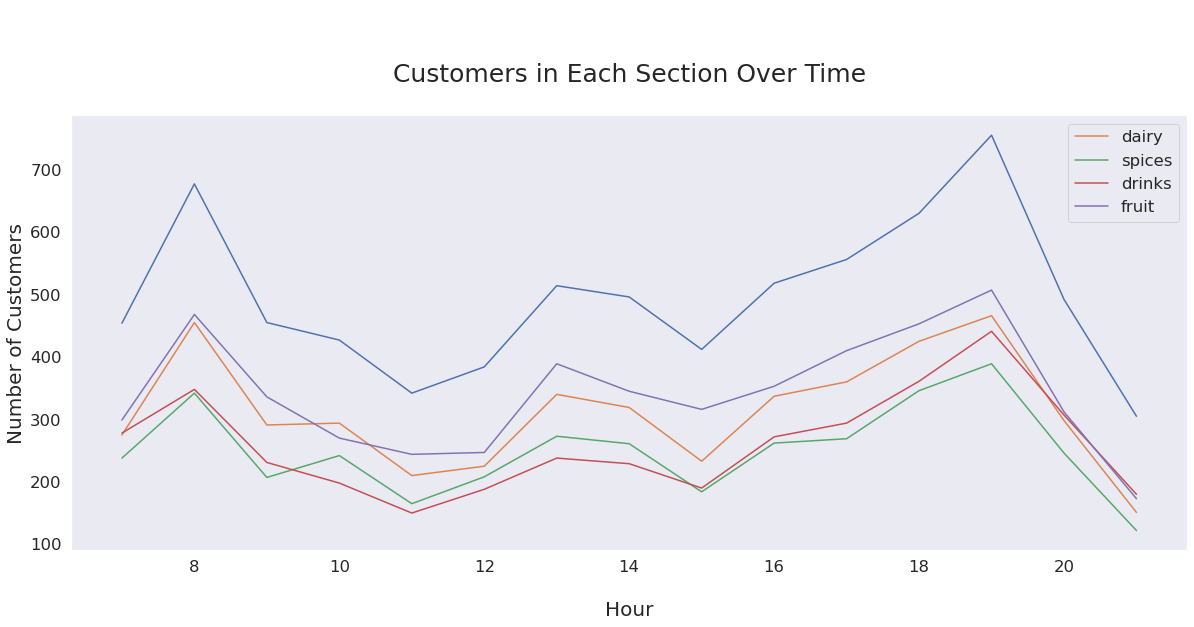

In [347]:
# Graph 3
# Display the number of customers at checkout (+ each section) over time

fig = plt.gcf()
fig.set_size_inches(20,8)

p = sns.lineplot(x=df['hour'].unique(), y=df.loc[df['location']=='checkout'].groupby('hour')['customer_no'].count())
p = sns.lineplot(x=df['hour'].unique(), y=df.loc[df['location']=='dairy'].groupby('hour')['customer_no'].count(), label='dairy')
p = sns.lineplot(x=df['hour'].unique(), y=df.loc[df['location']=='spices'].groupby('hour')['customer_no'].count(), label='spices')
p = sns.lineplot(x=df['hour'].unique(), y=df.loc[df['location']=='drinks'].groupby('hour')['customer_no'].count(), label = 'drinks')
p = sns.lineplot(x=df['hour'].unique(), y=df.loc[df['location']=='fruit'].groupby('hour')['customer_no'].count(), label = 'fruit')

p.set_xlabel("\nHour", fontsize = 20)
p.set_ylabel("Number of Customers", fontsize = 20)
p.set_title('\n\nCustomers in Each Section Over Time\n', fontsize = 25);

plt.savefig('customers_over_time.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
# plt.close()


In [348]:
minute_groups

,0
0,1 - 5 Minutes
1,1 - 5 Minutes
2,1 - 5 Minutes
3,1 - 5 Minutes
4,1 - 5 Minutes
...,...
7440,1 - 5 Minutes
7441,1 - 5 Minutes
7442,1 - 5 Minutes
7443,1 - 5 Minutes


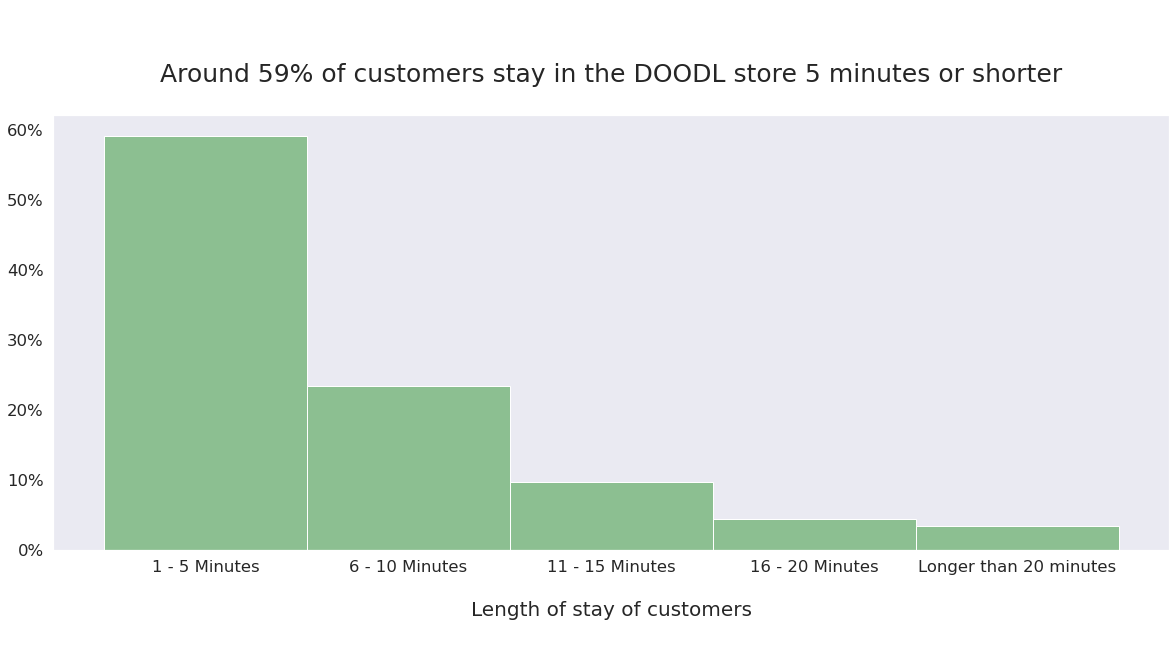

In [349]:
# Graph 4
# Calculate the time each customer spent in the market

fig = plt.gcf()
fig.set_size_inches(20,8)

p = sns.histplot(data=minute_groups[0], stat='percent', color="green", alpha=0.4)
p.yaxis.set_major_formatter(mtick.PercentFormatter())

p.set_xlabel("\nLength of stay of customers\n\n", fontsize = 20)
p.set_ylabel("")
p.set_title("\n\nAround 59% of customers stay in the DOODL store 5 minutes or shorter\n", fontsize = 25);

plt.savefig('length_of_stay.png', dpi=300, bbox_inches='tight', pad_inches=0)

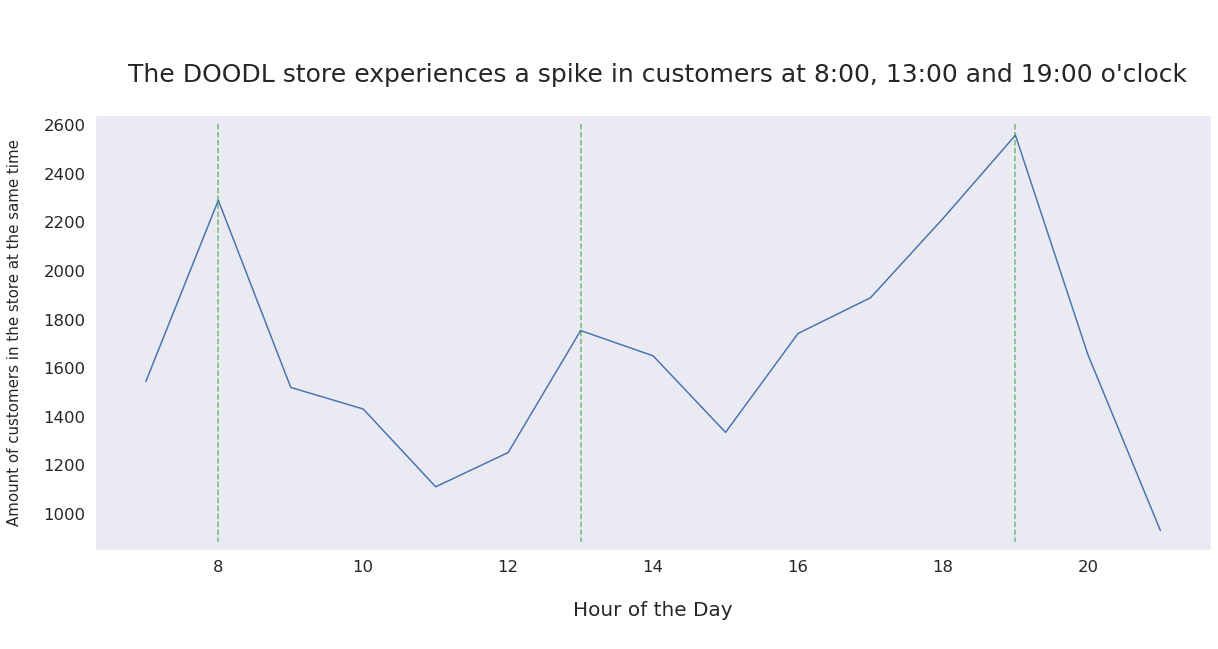

In [350]:
# Graph 5
# Calculate the total number of customers in the supermarket over time.

fig = plt.gcf()
fig.set_size_inches(20,8)

p = sns.lineplot(x=df['hour'].unique(), y=df.groupby('hour')['customer_no'].count())

p.set_xlabel("\nHour of the Day\n", fontsize = 20)
p.set_ylabel("Amount of customers in the store at the same time\n", fontsize = 15)

line1 = plt.axvline(8, 0.98,0.02, color='green', linestyle="--", alpha=0.5)
line3 = plt.axvline(13,0.98,0.02, color='green', linestyle="--", alpha=0.5)
line4 = plt.axvline(19,0.98,0.02, color='green', linestyle="--", alpha=0.5)

p.set_title("\n\n The DOODL store experiences a spike in customers at 8:00, 13:00 and 19:00 o'clock\n", fontsize = 25);
plt.savefig('customers_in_store_over_time.png', dpi=300, bbox_inches='tight', pad_inches=0)

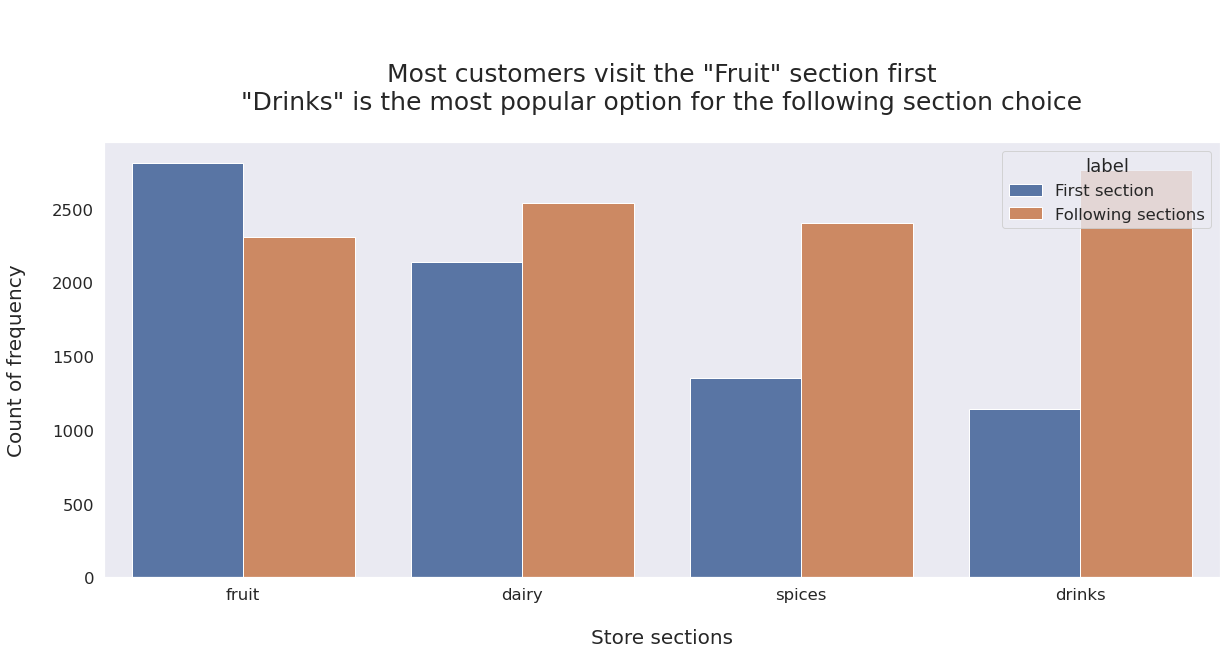

In [351]:
# Graph 6
# Our business managers think that the first section customers visit follows a different pattern than the following ones.
# Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

first_section_vc = df.groupby('customer_no').first()['location'].value_counts()
following_section_vc = df['location'].value_counts() - first_section_vc
following_section_vc.drop('checkout', inplace=True)
first_section_vc = pd.DataFrame(first_section_vc, columns=["location", "customers"]).reset_index(level=0)
first_section_vc.columns = ['location', 'customers', 'label']
first_section_vc['label'] = 'First section'
following_section_vc = pd.DataFrame(following_section_vc, columns=["location", "customers"]).reset_index(level=0)
following_section_vc.columns = ['location', 'customers', 'label']
following_section_vc['label'] = 'Following sections'
all_section_vs = pd.concat([first_section_vc, following_section_vc])
fig = plt.gcf()
fig.set_size_inches(20,8)
p = sns.barplot(x="location", y="customers", hue="label", data=all_section_vs)
p.set_xlabel("\nStore sections", fontsize = 20)
p.set_ylabel("Count of frequency\n", fontsize = 20)
p.set_title('\n\nMost customers visit the "Fruit" section first\n"Drinks" is the most popular option for the following section choice\n', fontsize = 25);
plt.savefig('section_popularity.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Produce a PDF Report

In [352]:
# Export Customer Behavior Report to PDF

class PDF(FPDF):
    def __init__(self):
        super().__init__()
        self.WIDTH = 210
        self.HEIGHT = 297
        
    def header(self):
        # Custom logo and positioning
        # Create an `assets` folder and put any wide and short image inside
        # Name the image `logo.png`
        self.image('assets/logo.png', 10, 8, 33)
        self.set_font('Arial', 'B', 11)
        self.cell(self.WIDTH - 80)
        self.cell(60, 1, 'DOODL Customer Behavior Report', 0, 0, 'R')
        self.ln(20)
        
    def footer(self):
        # Page numbers in the footer
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128)
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

    def page_body(self, images):
        # Determine how many plots there are per page and set positions
        # and margins accordingly
        if len(images) == 3:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
            self.image(images[2], 15, self.WIDTH / 2 + 90, self.WIDTH - 30)
        elif len(images) == 2:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
        else:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            
    def print_page(self, images):
        # Generates the report
        self.add_page()
        self.page_body(images)


In [353]:
PLOT_DIR = 'plots'

def construct():
    # Delete folder if exists and create it again
    try:
        shutil.rmtree(PLOT_DIR)
        os.mkdir(PLOT_DIR)
    except FileNotFoundError:
        os.mkdir(PLOT_DIR)
        
    # # Iterate over all months in 2020 except January
    # for i in range(2, 13):
    #     # Save visualization
    #     plot(data=generate_sales_data(month=i), filename=f'{PLOT_DIR}/{i}.png')
        
    # Construct data shown in document
    counter = 0
    pages_data = []
    temp = []

    # Get all plots
    files = os.listdir(PLOT_DIR)
    # Sort them by month - a bit tricky because the file names are strings
    # files = sorted(os.listdir(PLOT_DIR), key=lambda x: int(x.split('.')[0]))
    # Iterate over all created visualization
    for fname in files:
        # We want 3 per page
        if counter == 3:
            pages_data.append(temp)
            temp = []
            counter = 0

        temp.append(f'{PLOT_DIR}/{fname}')
        counter += 1

    return [*pages_data, temp]
    

In [354]:
plots_per_page = construct()
plots_per_page

[[]]

In [355]:
'''exportDate = date.today().strftime("%m_%d")

pdf = PDF()

    for elem in plots_per_page:
        pdf.print_page(elem)

pdf.output(f'{exportDate} - Customer Behavior Report.pdf', 'F')
'''

'exportDate = date.today().strftime("%m_%d")\n\npdf = PDF()\n\n    for elem in plots_per_page:\n        pdf.print_page(elem)\n\npdf.output(f\'{exportDate} - Customer Behavior Report.pdf\', \'F\')\n'

## Markov Monte Carlo

In [356]:
customer_paths['location'] = customer_paths['paths'].apply(lambda x: list(x))

In [358]:
customer_paths = customer_paths.explode('location')

In [359]:
customer_paths['next_location'] = customer_paths.groupby(['customer_no'])['location'].shift(-1)

In [360]:
customer_paths['next_location'].fillna('c', inplace=True)

In [361]:
customer_just_paths = customer_paths['paths']

In [362]:
trans_matrix = customer_paths.groupby('location')['next_location'].value_counts(normalize=True).unstack()

In [363]:
trans_matrix['e'] = 0

In [364]:
trans_matrix.fillna(0)

next_location,c,d,f,k,s,e
location,,,,,,
c,1.000000,0.000000,0.000000,0.000000,0.000000,0
d,0.103344,0.737061,0.049789,0.058500,0.051307,0
e,0.000000,0.287576,0.377435,0.153526,0.181464,0
f,0.201447,0.095848,0.597264,0.054804,0.050637,0
k,0.215688,0.010898,0.087900,0.598540,0.086974,0
s,0.150565,0.193061,0.090880,0.162979,0.402515,0


In [365]:
trans_matrix.index = ['checkout', 'dairy', 'entry', 'fruit', 'drinks', 'spices']

In [366]:
trans_matrix.columns = ['checkout', 'dairy', 'fruit', 'drinks', 'spices', 'entry']

In [367]:
trans_matrix_final = pd.DataFrame()

trans_matrix_final[['entry', 'dairy', 'fruit', 'drinks', 'spices', 'checkout']] = trans_matrix[['entry', 'dairy', 'fruit', 'drinks', 'spices', 'checkout']]

In [368]:
trans_matrix_final = trans_matrix_final.reindex(['entry', 'dairy', 'fruit', 'drinks', 'spices', 'checkout'])

In [369]:
trans_matrix_final.fillna(0, inplace=True)

In [370]:
trans_matrix_final

,entry,dairy,fruit,drinks,spices,checkout
entry,0,0.287576,0.377435,0.153526,0.181464,0.000000
dairy,0,0.737061,0.049789,0.058500,0.051307,0.103344
fruit,0,0.095848,0.597264,0.054804,0.050637,0.201447
drinks,0,0.010898,0.087900,0.598540,0.086974,0.215688
spices,0,0.193061,0.090880,0.162979,0.402515,0.150565
checkout,0,0.000000,0.000000,0.000000,0.000000,1.000000


In [371]:
trans_matrix_final.to_csv('data/trans_matrix.csv')

## Make visitors per minute matrix

In [372]:
new_visitors_per_hour = pd.DataFrame()

for i in range(7,22,1):
    new_visitors_per_hour = new_visitors_per_hour.append(df.loc[df['day']== 2].loc[df['hour'] == i].groupby('customer_no').first().sort_index())

new_visitors_per_hour = new_visitors_per_hour.groupby(['hour','minute']).count().drop(['location', 'day', 'month', 'year'], axis=1)

In [374]:
new_visitors_per_hour.columns = ['cu_amount']

In [375]:
new_visitors_per_hour.reset_index(inplace=True)

In [376]:
for hour in range(7,22,1):
    for minute in range(1,60,1):
        if new_visitors_per_hour.loc[(new_visitors_per_hour['hour']==hour) & (new_visitors_per_hour['minute']==minute)].empty:
            new_row = {'hour': hour, 'minute': minute, 'cu_amount': 0}
            new_visitors_per_hour = new_visitors_per_hour.append(new_row, ignore_index=True)
        else:
            pass

In [377]:
new_visitors_per_minute = new_visitors_per_hour.groupby('hour')['cu_amount'].value_counts(normalize=True).sort_index()

In [378]:
new_customers = pd.DataFrame(columns=[i for i in range(21)])

In [379]:
new_customers=new_customers.rename(columns = {0:'hour'})

In [380]:
new_visitors_per_minute = pd.DataFrame(new_visitors_per_minute)

In [381]:
new_visitors_per_minute.columns = ['perc']

In [382]:
new_visitors_per_minute.reset_index(inplace=True)

In [383]:
new_visitors_per_minute = new_visitors_per_minute.pivot(index='hour', columns='cu_amount', values='perc').fillna(0)

In [384]:
new_visitors_per_minute

cu_amount,0,1,2,3,4,5,6,7,8,9
hour,,,,,,,,,,
7,0.474576,0.084746,0.152542,0.067797,0.067797,0.084746,0.050847,0.000000,0.016949,0.000000
8,0.333333,0.150000,0.100000,0.166667,0.150000,0.050000,0.016667,0.016667,0.016667,0.000000
9,0.366667,0.166667,0.250000,0.066667,0.066667,0.033333,0.016667,0.016667,0.016667,0.000000
10,0.483333,0.133333,0.083333,0.133333,0.066667,0.016667,0.066667,0.016667,0.000000,0.000000
11,0.566667,0.150000,0.116667,0.100000,0.033333,0.016667,0.016667,0.000000,0.000000,0.000000
12,0.416667,0.183333,0.183333,0.133333,0.016667,0.033333,0.016667,0.016667,0.000000,0.000000
13,0.300000,0.116667,0.166667,0.166667,0.150000,0.016667,0.050000,0.033333,0.000000,0.000000
14,0.450000,0.133333,0.166667,0.083333,0.066667,0.000000,0.083333,0.016667,0.000000,0.000000
15,0.450000,0.083333,0.150000,0.150000,0.083333,0.050000,0.016667,0.000000,0.000000,0.016667


In [385]:
new_visitors_per_minute.to_csv('data/new_visitors_per_minute.csv')